In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.special import inv_boxcox
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sample_data_path = '../../v1_1/data/RIbench/Data/'


In [2]:
params = pd.read_csv('./SpecificationTestSets.csv') # get RIbench test set parameters

params = params[(params.Analyte!='CRP') & (params.Analyte!='LDH')] # don't include CRP
# params = params[params.Analyte!='LDH'] # don't include CRP
params = params[params.fractionPathol==0.50]

# get all the unique component parameters
subset_cols = ['nonp_mu', 'nonp_sigma', 'nonp_lambda', 'left_mu', 'left_sigma', 'right_mu', 'right_sigma', 'bg_max', 'bg_min']
params = params.drop_duplicates(subset=subset_cols)
params = params.reset_index(drop=True)


In [3]:
params.shape[0]


144

In [4]:
import scipy.optimize as opt
from scipy.stats import norm, halfnorm

# define the exponential decay and linear fit functions
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def linear(x, a, b):
    return a * x + b

# class for m
class RIbenchModeler:
    def __init__(self, bin_shift, max_skew):
        self.bin_shift = bin_shift
        self.max_skew = max_skew
        self.bin_starts = np.arange(0, max_skew, bin_shift)
        self.min_std = 0.1
        self.min_mean_abs = 0
        self.fits = {}
        self.data = {}

    def fit(self, plot=False):
        '''
        Model the parameters of RIbench mixtures
        as functions of the reference component skew
        
        '''
        
        bin_starts = self.bin_starts

        x_data = ref_skew_sorted[ref_skew_sorted<=max_skew]
        self.data['x_data'] = x_data
        
        # left pathological means - both parameters modeled with exp. decay
        # we use binning to have uniform influence of fitting across x range
        # fit mean
        bin_width = 3
        self.data['left_mean_abs'] = left_mean_abs[ref_skew_sorted<=max_skew]
        y_data = self.data['left_mean_abs']
        means = np.array([np.mean(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        # fit std
        stds = np.array([np.std(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popv, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, stds, nan_policy='omit')
        # store the fits
        self.fits['left_mean_abs'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': exp_decay, 'params': popv}
        }
        
        # right pathological means
        bin_width = 3
        self.data['right_mean'] = right_mean[ref_skew_sorted<=max_skew]
        y_data = self.data['right_mean']
        means = np.array([np.mean(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        stds = np.array([np.std(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popv, _ = opt.curve_fit(linear, bin_starts+bin_width/2, stds, nan_policy='omit')
        self.fits['right_mean'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': linear, 'params': popv}
        }
        
        # left stds
        bin_width = 3
        self.data['left_std'] = left_std[ref_skew_sorted<=max_skew]
        y_data = self.data['left_std']
        means = np.array([np.mean(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        stds = np.array([np.std(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popv, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, stds, nan_policy='omit')
        self.fits['left_std'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': exp_decay, 'params': popv}
        }
        
        # right stds
        bin_width = 3
        self.data['right_std'] = right_std[ref_skew_sorted<=max_skew]
        y_data = self.data['right_std']
        means = np.array([np.mean(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        stds = np.array([np.std(y_data[(x_data>=i) & (x_data<(i+bin_width))]) for i in bin_starts])
        popv, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, stds, nan_policy='omit')
        self.fits['right_std'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': exp_decay, 'params': popv}
        }
        
        # left_edge (same as background minimum)
        self.data['left_edge_abs'] = left_edge_abs[ref_skew_sorted<=max_skew]
        y_data = self.data['left_edge_abs']
        popm, _ = opt.curve_fit(exp_decay, x_data[x_data>=0.1], y_data[x_data>=0.1])
        self.fits['left_edge_abs'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': linear, 'params': [-50, 9]}
        }
        
        # bg_max
        self.data['bg_max'] = bg_max[ref_skew_sorted<=max_skew]
        y_data = self.data['bg_max']
        popm, _ = opt.curve_fit(exp_decay, x_data[x_data>=0.1], y_data[x_data>=0.1])
        self.fits['bg_max'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': linear, 'params': [-50*10, 80]}
        }
    
        # nonp lambda
        temp_lambda = []
        temp_skew = []
        repeats = 10
        self.data['nonp_lambda'] = {'x':[], 'y':[]}
        for i in np.linspace(1, 0, 20): # loop inv_boxcox lambdas
            for repeat in range(repeats): # repeat for each one
                temp_data = np.random.normal(2.571, 1.104715, 10000) # take data
                temp_data = scipy.special.inv_boxcox(temp_data[temp_data>=0], i) # transform 
                temp_data -= temp_data.mean() # standardize
                temp_data /= temp_data.std()
                temp_lambda.append(i) # record lambda and skew
                temp_skew.append(scipy.stats.skew(temp_data))
                self.data['nonp_lambda']['x'].append(temp_skew[-1])
                self.data['nonp_lambda']['y'].append(temp_lambda[-1])
        temp_lambda = np.array(temp_lambda)
        temp_skew = np.array(temp_skew)
        bin_width = 1
        means = np.array([np.mean(temp_lambda[(temp_skew>=i) & (temp_skew<(i+bin_width))]) for i in bin_starts])
        popm, _ = opt.curve_fit(exp_decay, bin_starts+bin_width/2, means, nan_policy='omit')
        self.fits['nonp_lambda'] = {
            'mean': {'func': exp_decay, 'params': popm},
            'std': {'func': linear, 'params': [0, 0]}
        }
        del temp_lambda, temp_skew, repeats
        
        if plot:
            plt.figure(figsize=(12, 8))
            plt.subplot(4,2,1)
            self.plot_fit('left_mean_abs')
            plt.subplot(4,2,2)
            self.plot_fit('right_mean')
            plt.subplot(4,2,3)
            self.plot_fit('left_std')
            plt.subplot(4,2,4)
            self.plot_fit('right_std')
            plt.subplot(4,2,5)
            self.plot_fit('left_edge_abs')
            plt.subplot(4,2,6)
            self.plot_fit('bg_max')
            plt.subplot(4,2,7)
            self.plot_fit('nonp_lambda')
            plt.tight_layout()
            

    def plot_fit(self, param_name, legend=True):
        '''
        Plot fitted parameter functions
        '''
        x = np.linspace(0, 10, 200)
        if param_name!='nonp_lambda':
            plt.scatter(self.data['x_data'], self.data[param_name], alpha=0.25, s=10, label='RIBench Values')
        else:
            plt.scatter(self.data[param_name]['x'], self.data[param_name]['y'], alpha=0.25, s=10)
        plt.plot(x, np.maximum(self.min_mean_abs, self.fits[param_name]['mean']['func'](x, *self.fits[param_name]['mean']['params'])), c='r', label='Mean')
        if param_name not in ['left_edge_abs', 'bg_max']:
            plt.plot(
                x, 
                [
                    np.maximum(self.min_std, norm(
                        self.fits[param_name]['mean']['func'](i, *self.fits[param_name]['mean']['params']), 
                        self.fits[param_name]['std']['func'](i, *self.fits[param_name]['std']['params'])).ppf(0.025)) \
                    for i in x
                ], c='k', linestyle=':'
            )
            plt.plot(
                x, 
                [
                    np.maximum(self.min_std, norm(
                        self.fits[param_name]['mean']['func'](i, *self.fits[param_name]['mean']['params']), 
                        self.fits[param_name]['std']['func'](i, *self.fits[param_name]['std']['params'])).ppf(0.975)) \
                    for i in x
                ], c='k', linestyle=':', label='95% Interval'
            ) 
        else:
            plt.plot(
                x, 
                [
                    np.maximum(self.min_std, norm(
                        self.fits[param_name]['mean']['func'](i, *self.fits[param_name]['mean']['params']), 
                        self.fits[param_name]['std']['func'](i, *self.fits[param_name]['std']['params'])).ppf(0.95)) \
                    for i in x
                ], c='k', linestyle=':', label='95% Interval'
            ) 
        plt.title(param_name)
        if legend:
            plt.legend();
        

    def generate(self, ref_skew):
        '''
        Generate pathological component parameters based on the fits and a reference skew
        '''
        params = {}
        for key in self.fits.keys(): # loop over mixture parameters
            if key!='nonp_lambda': # for lambda, don't use variance
                if key not in ['left_edge_abs', 'bg_max']:
                    
                    # sample using gaussian
                    model = norm( # create gaussian for sampling current parameter
                        loc=self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params']), 
                        scale=np.maximum(0, self.fits[key]['std']['func'](ref_skew, *self.fits[key]['std']['params']))
                    )
                    params[key] = model.rvs(1)
                        
                else:
                    
                    # a half-distribution is used for left edge and bg max; only varies with skew~0
                    model = halfnorm( 
                        loc=self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params']), 
                        scale=np.maximum(0, self.fits[key]['std']['func'](ref_skew, *self.fits[key]['std']['params']))
                    )
                    params[key] = model.rvs(1)
                        
                if 'mean' in key: # put limits
                    params[key] = np.maximum(self.min_mean_abs, params[key])
                if 'std' in key:
                    params[key] = np.maximum(self.min_std, params[key])
            else: # for lambda there is no variance
                params[key] = self.fits[key]['mean']['func'](ref_skew, *self.fits[key]['mean']['params'])
        # make sure left component is not too low based on the left edge
        params['left_mean_abs'] = -np.maximum(-params['left_edge_abs']-params['left_std'], -params['left_mean_abs'])
        return params

# Example usage:
bin_shift = 1  # skew bin shift
max_skew = 10

# Create an instance of DataModeler
modeler = RIbenchModeler(bin_shift, max_skew)


In [5]:
if os.path.exists('./modeler_2.pkl'):
    modeler = pickle.load(open('./modeler_2.pkl', 'rb'))
    

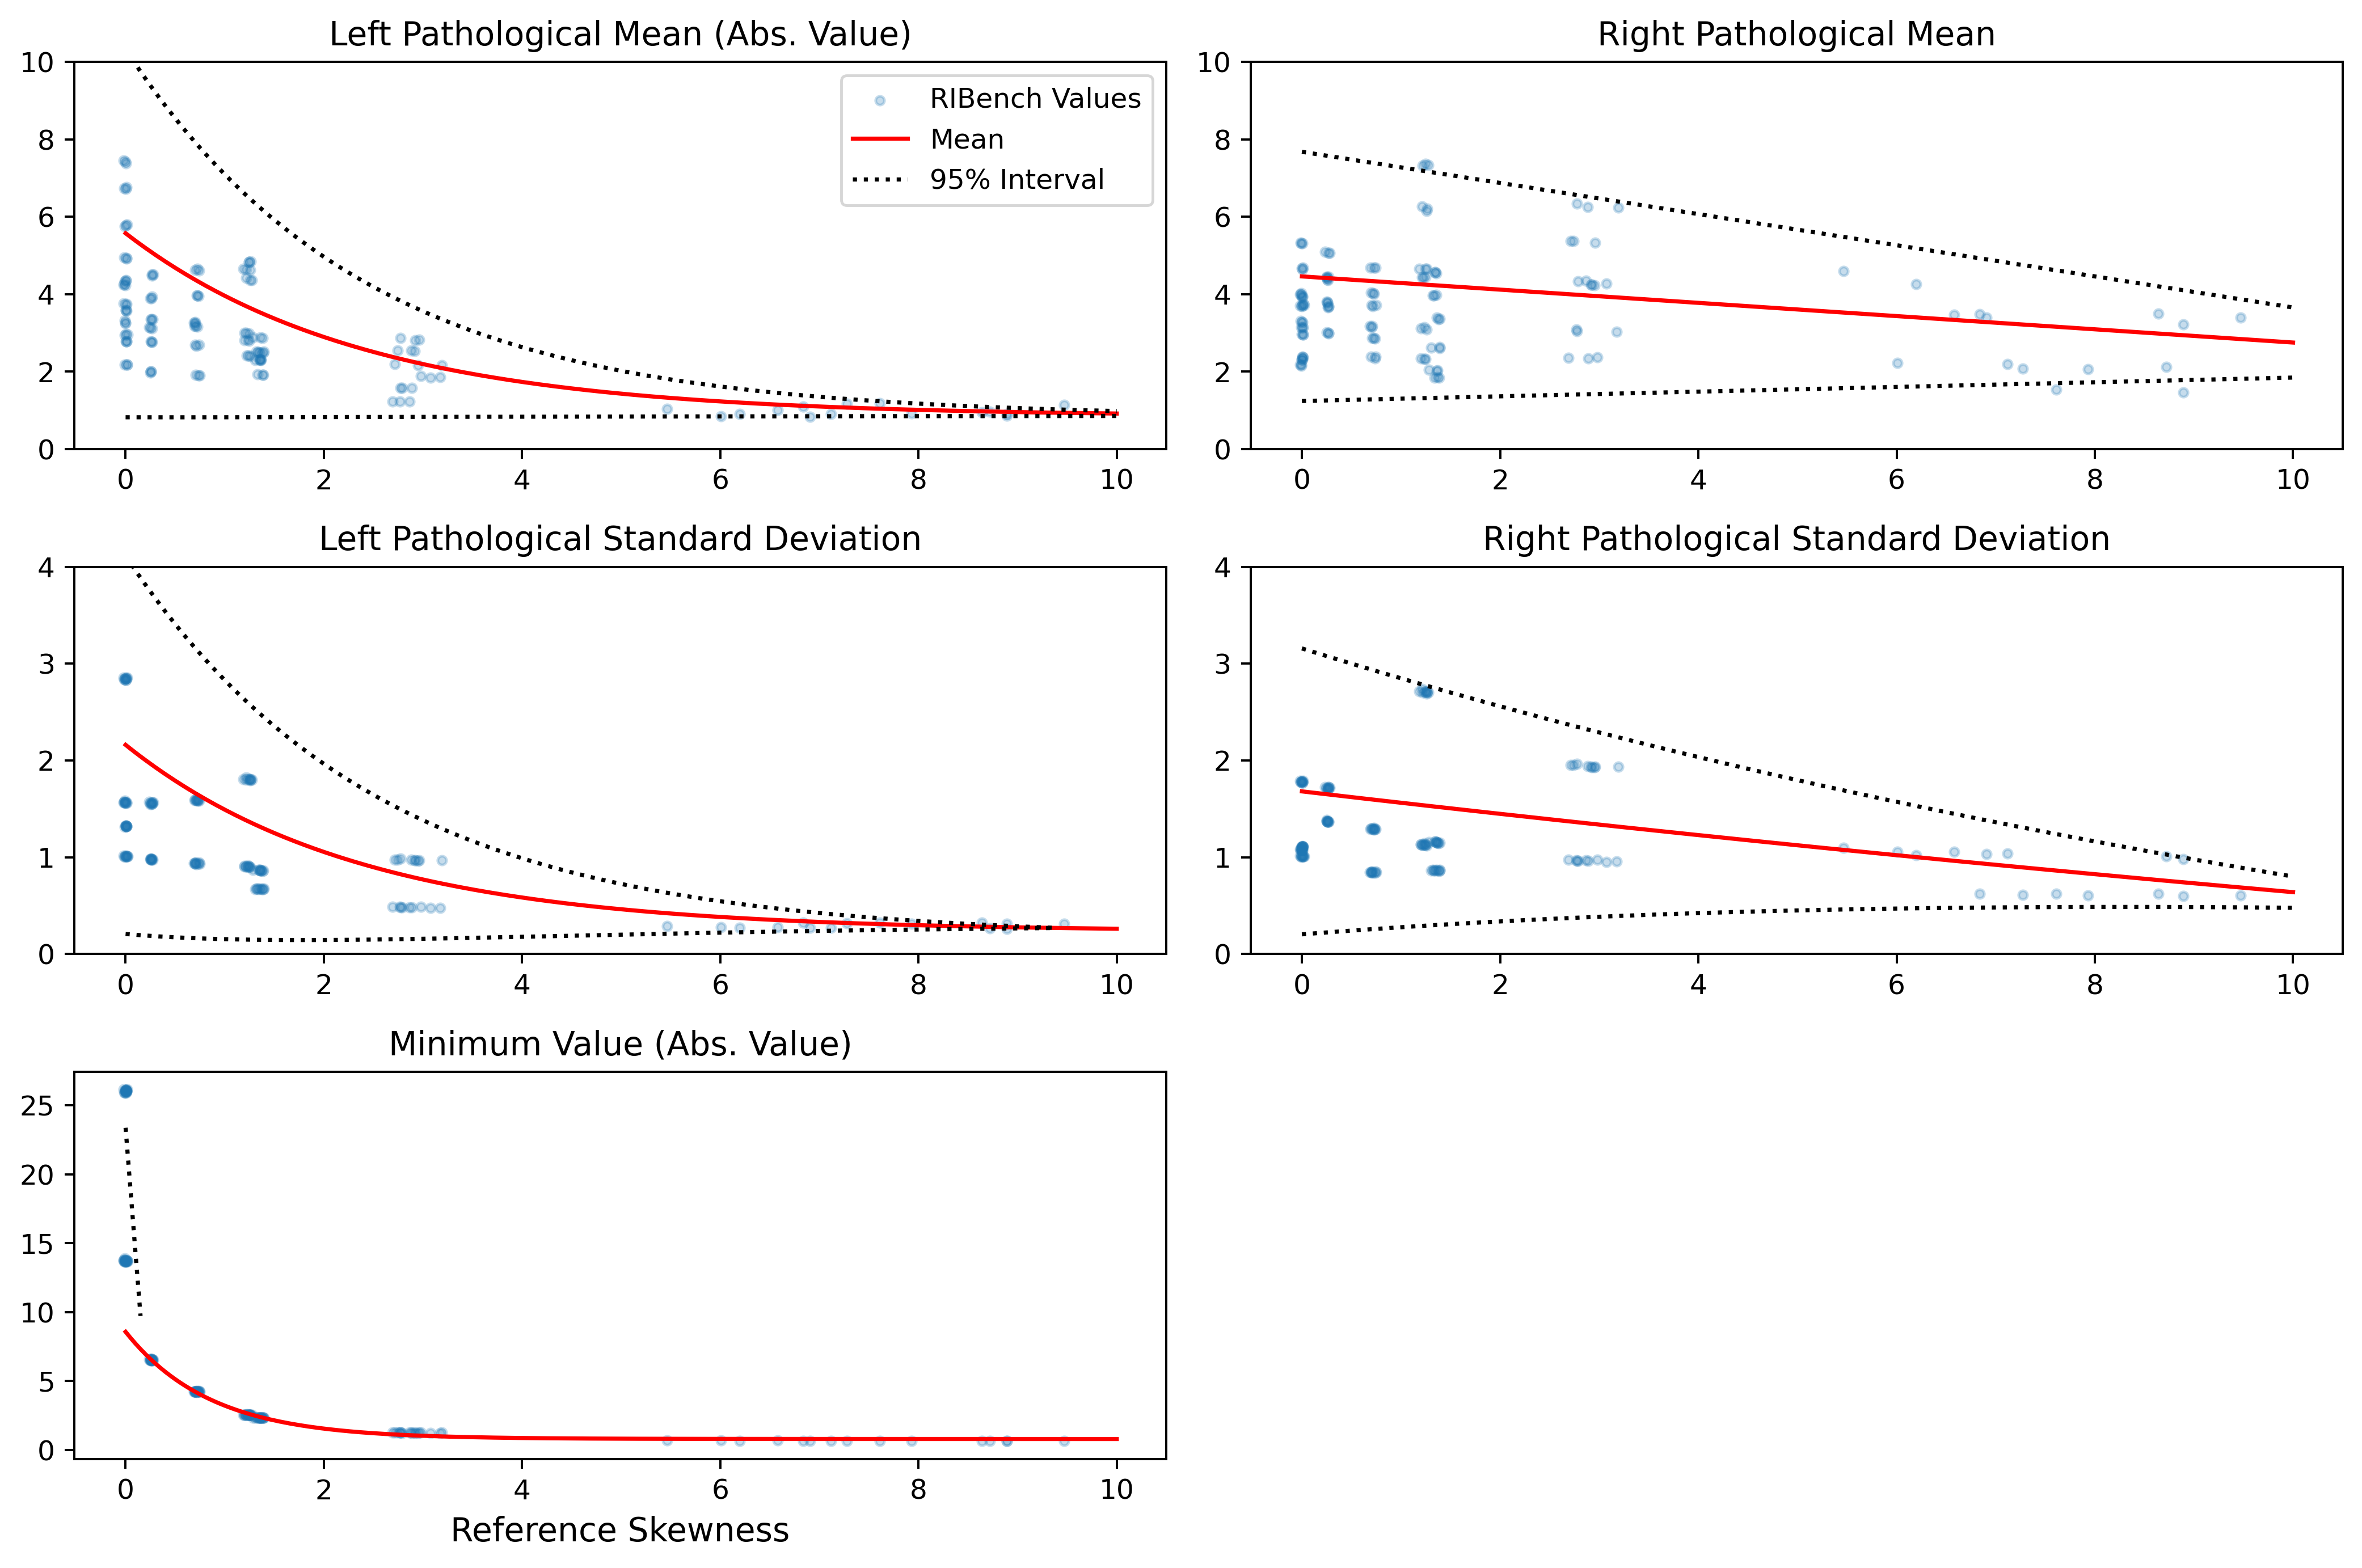

In [6]:
# plot the fits to each distribution parameter

plt.figure(figsize=(12, 8), dpi=350)
plt.subplot(3,2,1)
modeler.plot_fit('left_mean_abs', legend=True)
plt.title('Left Pathological Mean (Abs. Value)')
plt.ylim([0, 10])

plt.subplot(3,2,2)
modeler.plot_fit('right_mean', legend=False)
plt.title('Right Pathological Mean')
plt.ylim([0, 10])

plt.subplot(3,2,3)
modeler.plot_fit('left_std', legend=False)
plt.title('Left Pathological Standard Deviation')
plt.ylim([0, 4])

plt.subplot(3,2,4)
modeler.plot_fit('right_std', legend=False)
plt.title('Right Pathological Standard Deviation')
plt.ylim([0, 4])

plt.subplot(3,2,5)
modeler.plot_fit('left_edge_abs', legend=False)
plt.title('Minimum Value (Abs. Value)')
plt.xlabel('Reference Skewness', fontsize=12)

# plt.subplot(3,2,6)
# modeler.plot_fit('nonp_lambda')
# plt.title('Z')

plt.tight_layout()


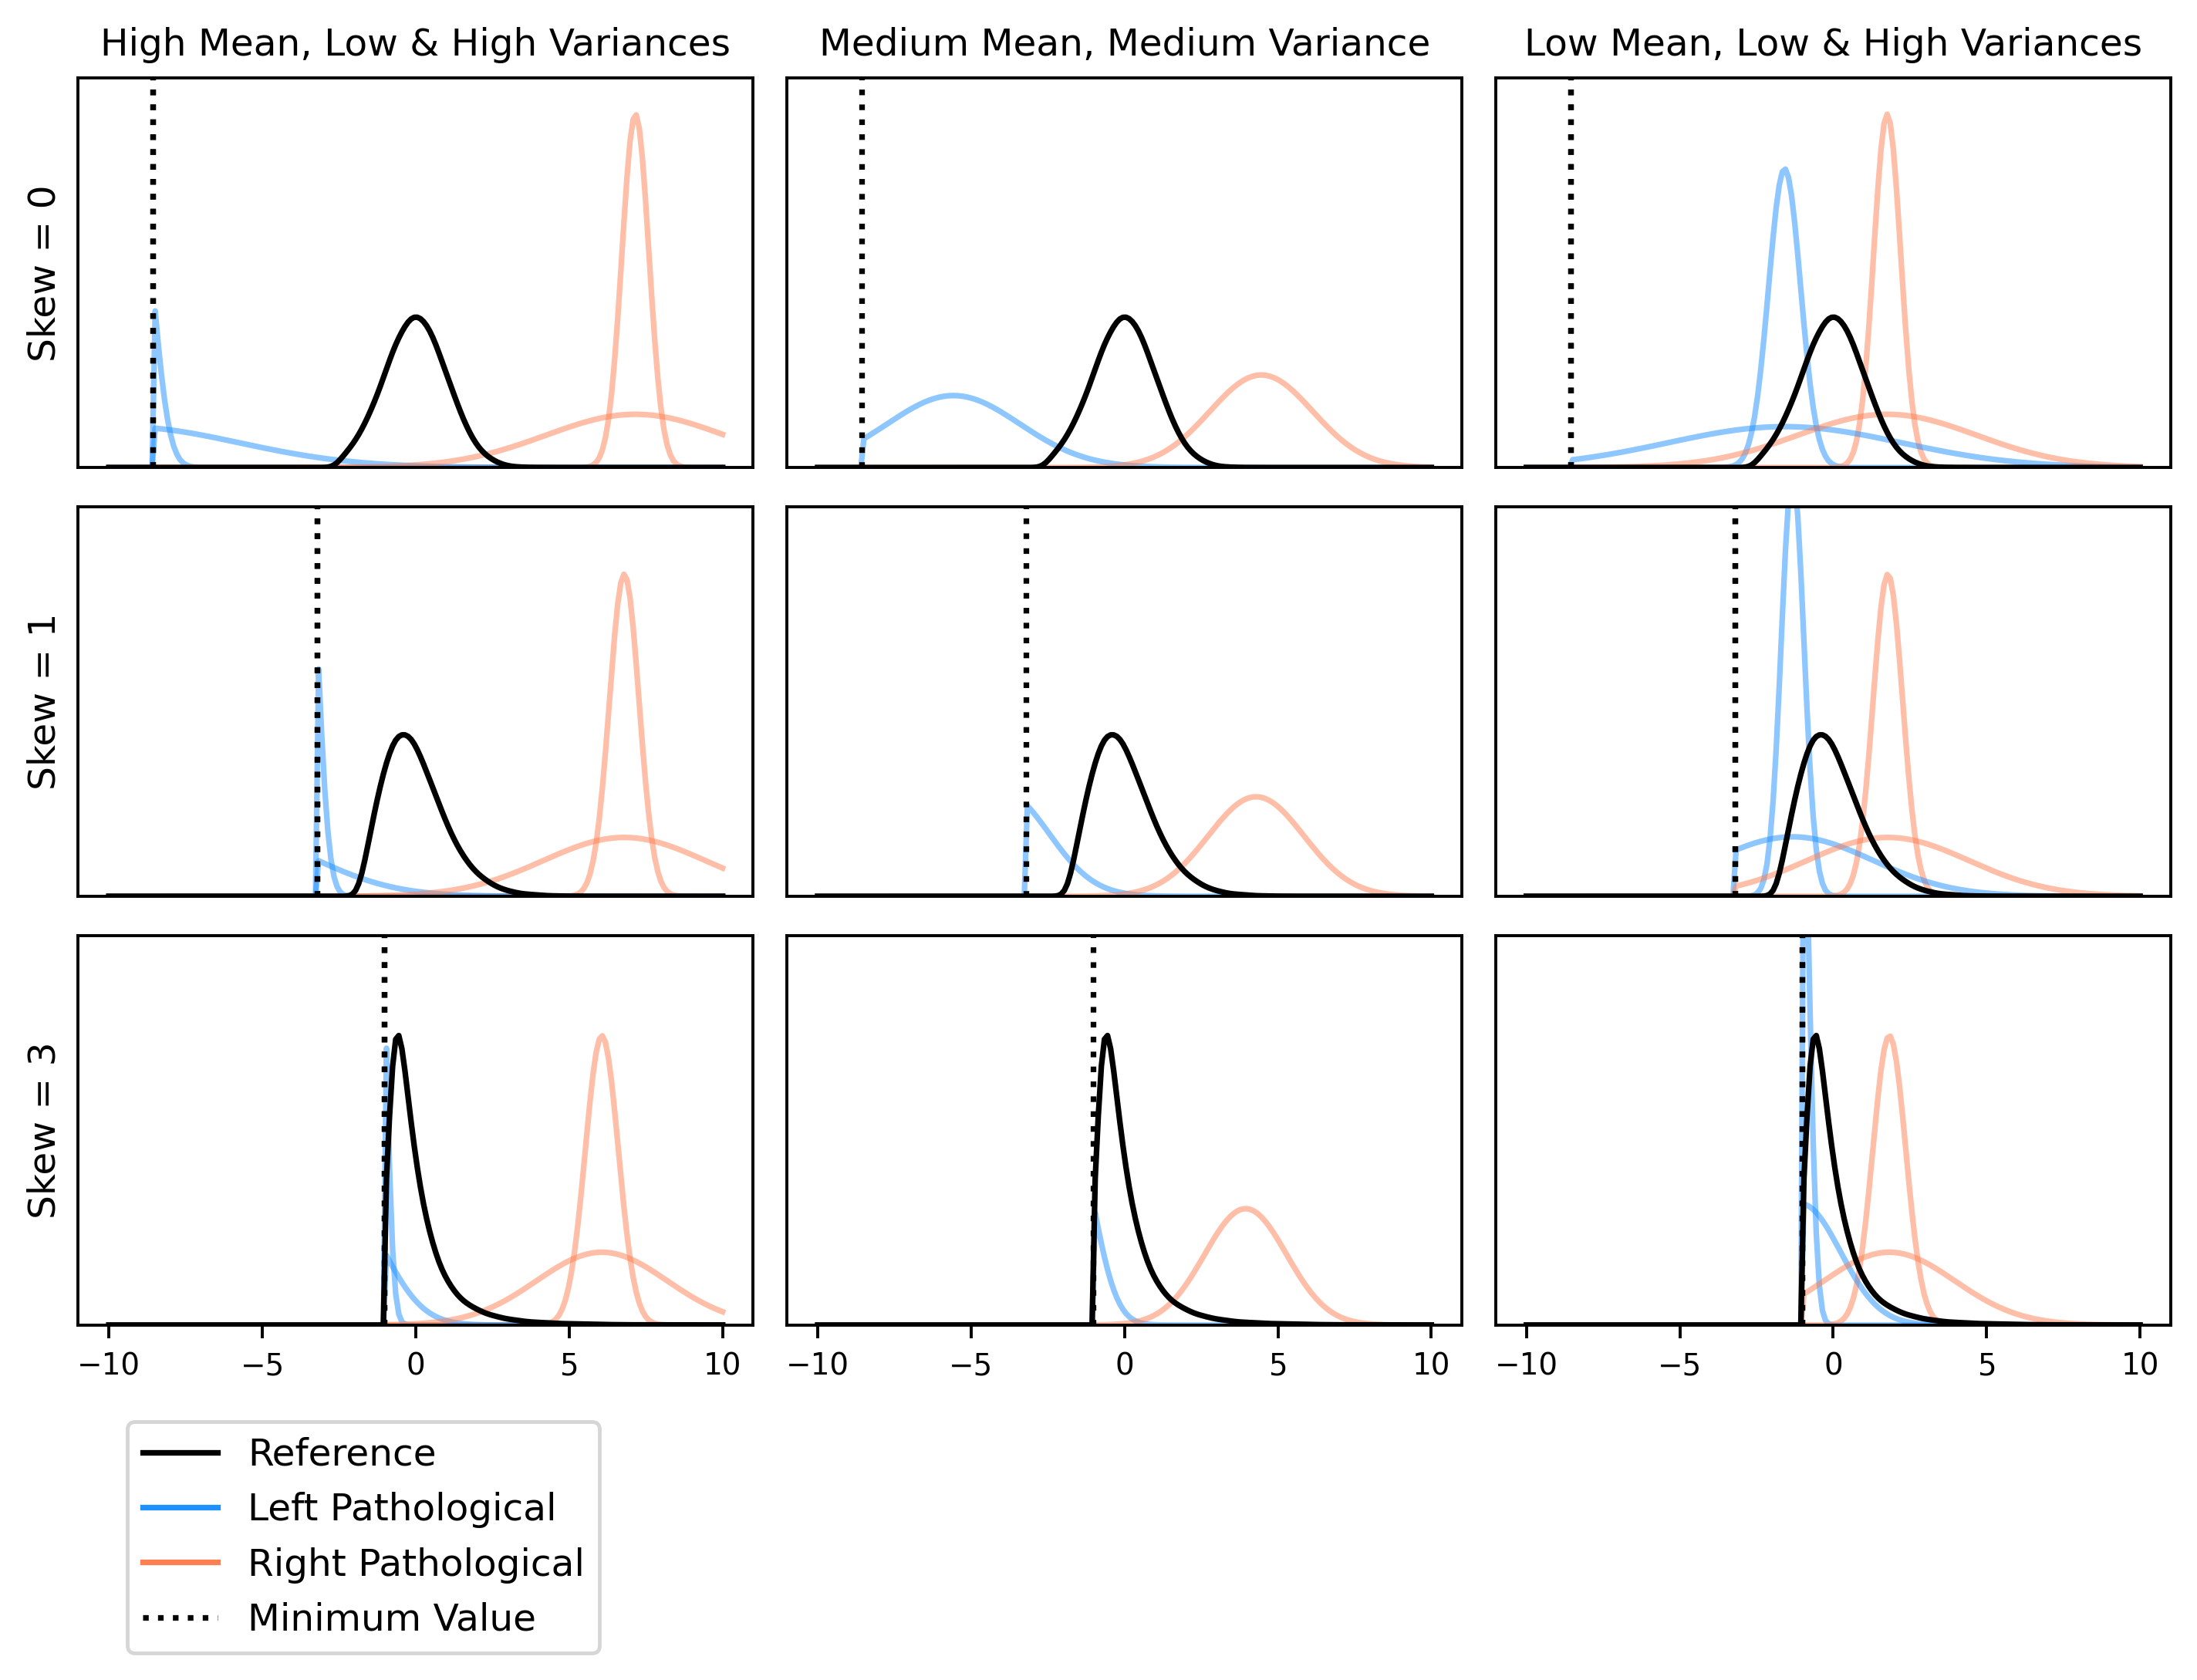

In [7]:
# get parameters at low skew, at 95% limits

x_range = np.linspace(-10, 10, 200) # define x range for plot
fit_keys = ['left_mean_abs', 'right_mean', 'left_std', 'right_std', 'left_edge_abs', 'bg_max']

# define reference skew
ref_skew = 0

# get lambda parameter
nonp_lambda = modeler.fits['nonp_lambda']['mean']['func'](ref_skew, *modeler.fits['nonp_lambda']['mean']['params'])

# get reference pdf
ref_norm = norm(loc=2.571, scale=1.104715)
ref_data = ref_norm.rvs(100000)
ref_data = scipy.special.inv_boxcox(ref_data[ref_data>=0], nonp_lambda)
ref_mean = ref_data.mean()
ref_std = ref_data.std()
ref_data -= ref_mean
ref_data /= ref_std
ref_kde = scipy.stats.gaussian_kde(ref_data, bw_method=0.2) # get KDE for plotting
ref_pdf = ref_kde(x_range)

# function for plotting pathological pdfs at various parameter ppfs for a given reference skew
def subplot(ppf_values, legend=False):

    for pset in range(len(ppf_values)):
        
        params = {}
        for c,key in enumerate(fit_keys): # loop over mixture parameters
            if key not in ['left_edge_abs', 'bg_max']:
                # sample using gaussian
                model = norm( # create gaussian for sampling current parameter
                    loc=modeler.fits[key]['mean']['func'](ref_skew, *modeler.fits[key]['mean']['params']), 
                    scale=np.maximum(0, modeler.fits[key]['std']['func'](ref_skew, *modeler.fits[key]['std']['params']))
                )
                params[key] = model.ppf(ppf_values[pset][c])
            else:
                # a half-distribution is used for left edge and bg max; only varies with skew~0
                params[key] = modeler.fits[key]['mean']['func'](ref_skew, *modeler.fits[key]['mean']['params'])
            if 'mean' in key: # put limits
                params[key] = np.maximum(modeler.min_mean_abs, params[key])
            if 'std' in key:
                params[key] = np.maximum(modeler.min_std, params[key])
        # make sure left component is not too low based on the left edge
        params['left_mean_abs'] = -np.maximum(-params['left_edge_abs']-params['left_std'], -params['left_mean_abs'])
        
        # plot
        left_norm = norm(loc=-params['left_mean_abs'], scale=params['left_std'])
        left_pdf = left_norm.pdf(x_range)
        left_pdf[x_range<=-params['left_edge_abs']]=0
        plt.plot(x_range, left_pdf, c='dodgerblue', alpha=0.5, label='Possible Left Pathologicals')
        right_norm = norm(loc=params['right_mean'], scale=params['right_std'])
        right_pdf = right_norm.pdf(x_range)
        right_pdf[x_range<=-params['left_edge_abs']]=0
        plt.plot(x_range, right_pdf, c='coral', alpha=0.5, label='Possible Right Pathologicals')
        plt.axvline(-params['left_edge_abs'], c='k', linestyle=':', label='Minimum Value')
        
    ref_pdf[x_range<=-params['left_edge_abs']]=0
    plt.plot(x_range, ref_pdf, c='k', label='Reference')
    plt.yticks([])

    plt.ylim([0, 1.0])
    plt.xticks(fontsize=8)
    

plt.figure(figsize=(10, 6), dpi=350)

plt.subplot(3, 3, 1)
subplot(
    [
        [0.95, 0.95, 0.05, 0.05], 
        [0.95, 0.95, 0.95, 0.95],
    ], 
    legend=False
)
plt.xticks([])
plt.title('High Mean, Low & High Variances', fontsize=10)
plt.ylabel('Skew = 0')

plt.subplot(3, 3, 2)
subplot(
    [
        [0.5, 0.5, 0.5, 0.5],
    ], 
    legend=False
)
plt.xticks([])
plt.title('Medium Mean, Medium Variance', fontsize=10)

plt.subplot(3, 3, 3)
subplot(
    [
        [0.05, 0.05, 0.05, 0.05], 
        [0.05, 0.05, 0.95, 0.95],
    ], 
    legend=False
)
plt.xticks([])
plt.title('Low Mean, Low & High Variances', fontsize=10)

# define reference skew
ref_skew = 1

# get lambda parameter
nonp_lambda = modeler.fits['nonp_lambda']['mean']['func'](ref_skew, *modeler.fits['nonp_lambda']['mean']['params'])

# get reference pdf
ref_norm = norm(loc=2.571, scale=1.104715)
ref_data = ref_norm.rvs(100000)
ref_data = scipy.special.inv_boxcox(ref_data[ref_data>=0], nonp_lambda)
ref_mean = ref_data.mean()
ref_std = ref_data.std()
ref_data -= ref_mean
ref_data /= ref_std
ref_kde = scipy.stats.gaussian_kde(ref_data, bw_method=0.2) # get KDE for plotting
ref_pdf = ref_kde(x_range)

plt.subplot(3, 3, 4)
subplot(
    [
        [0.95, 0.95, 0.05, 0.05], 
        [0.95, 0.95, 0.95, 0.95],
    ], 
    legend=False
)
plt.xticks([])
plt.ylabel('Skew = 1')

plt.subplot(3, 3, 5)
subplot(
    [
        [0.5, 0.5, 0.5, 0.5],
    ], 
    legend=False
)
plt.xticks([])
plt.subplot(3, 3, 6)
subplot(
    [
        [0.05, 0.05, 0.05, 0.05], 
        [0.05, 0.05, 0.95, 0.95],
    ], 
    legend=False
)
plt.xticks([])

# define reference skew
ref_skew = 3

# get lambda parameter
nonp_lambda = modeler.fits['nonp_lambda']['mean']['func'](ref_skew, *modeler.fits['nonp_lambda']['mean']['params'])

# get reference pdf
ref_norm = norm(loc=2.571, scale=1.104715)
ref_data = ref_norm.rvs(100000)
ref_data = scipy.special.inv_boxcox(ref_data[ref_data>=0], nonp_lambda)
ref_mean = ref_data.mean()
ref_std = ref_data.std()
ref_data -= ref_mean
ref_data /= ref_std
ref_kde = scipy.stats.gaussian_kde(ref_data, bw_method=0.2) # get KDE for plotting
ref_pdf = ref_kde(x_range)

plt.subplot(3, 3, 7)
subplot(
    [
        [0.95, 0.95, 0.05, 0.05], 
        [0.95, 0.95, 0.95, 0.95],
    ], 
    legend=False
)
plt.ylabel('Skew = 3')

plt.subplot(3, 3, 8)
subplot(
    [
        [0.5, 0.5, 0.5, 0.5],
    ], 
    legend=False
)
plt.subplot(3, 3, 9)
subplot(
    [
        [0.05, 0.05, 0.05, 0.05], 
        [0.05, 0.05, 0.95, 0.95],
    ], 
    legend=False
)

plt.subplots_adjust(wspace=0.05, hspace=0.1)

# create the legend
line1, = plt.gca().plot([], [], 'k-', label='Reference')
line2, = plt.gca().plot([], [], c='dodgerblue', label='Left Pathological')
line3, = plt.gca().plot([], [], c='coral', label='Right Pathological')
line4, = plt.gca().plot([], [], 'k:', label='Minimum Value')
legend = plt.gca().legend(handles=[line1, line2, line3, line4], bbox_to_anchor=(-1.3, -0.2))
plt.show()


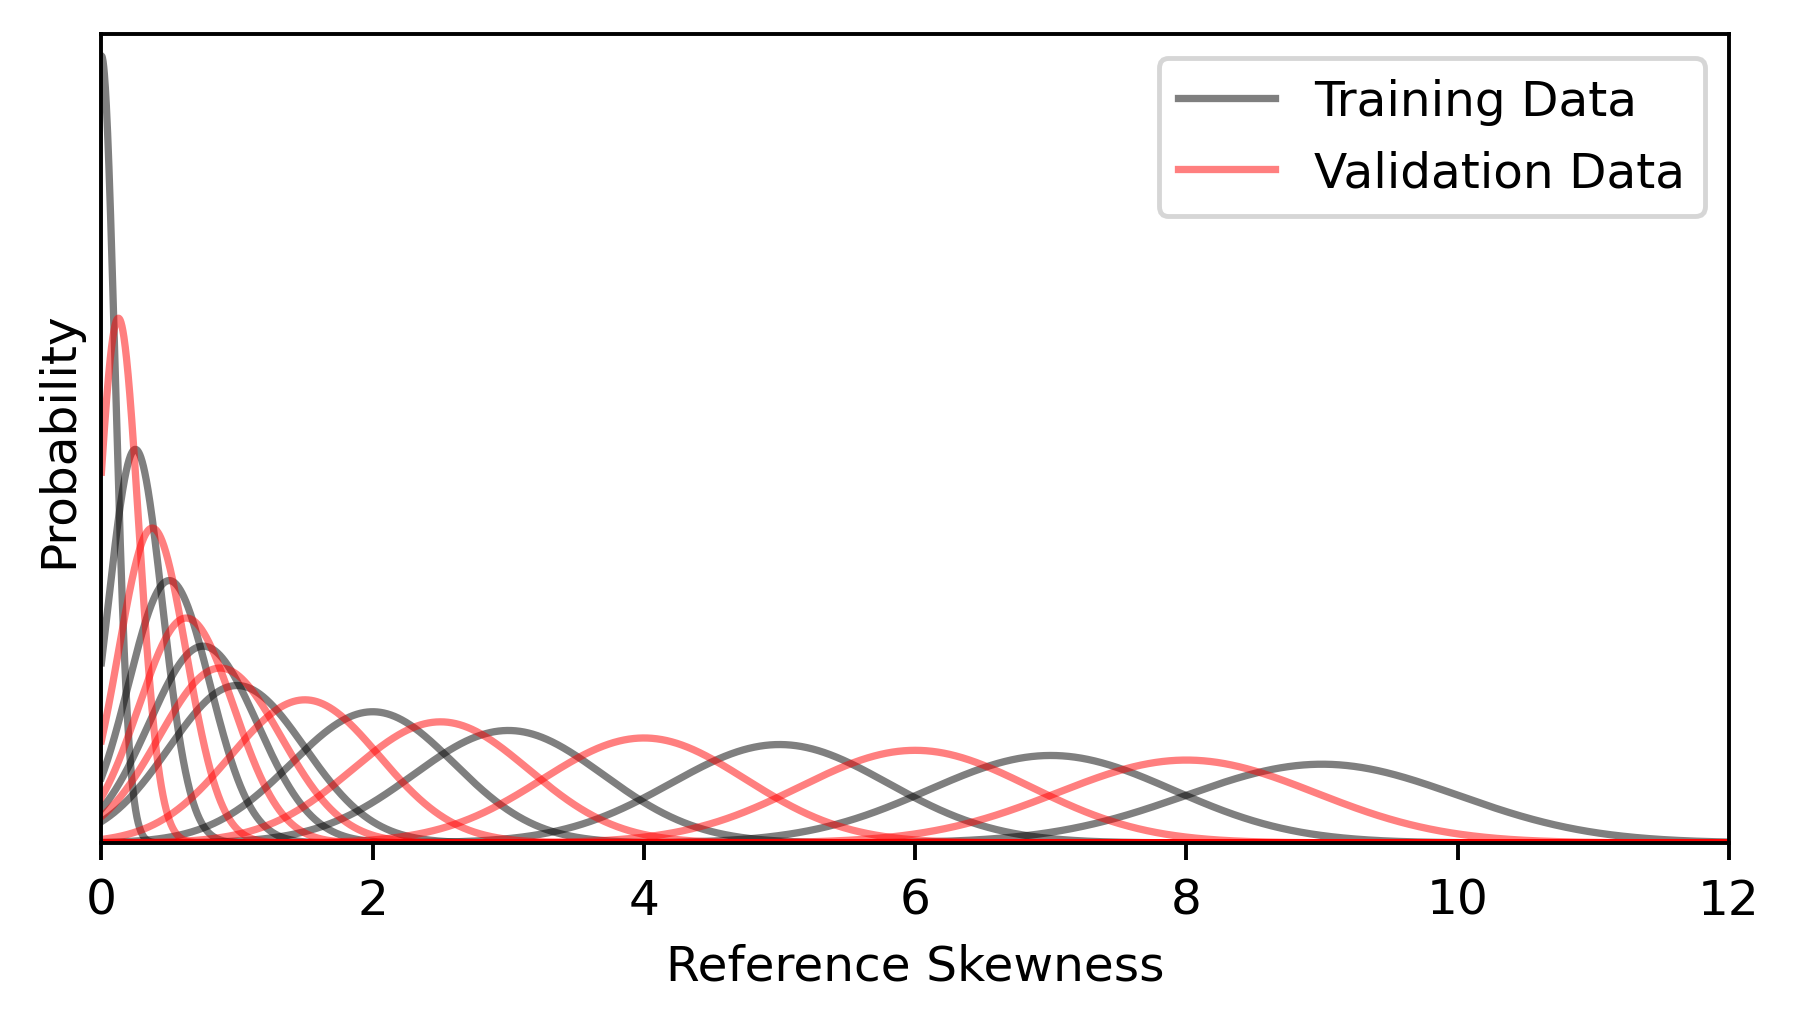

In [12]:
# define training skews
skews_mean = np.array([0.00, 0.25, 0.50, 0.75, 1.00, 2.00, 3.00, 5.00, 7.00, 9.00])
skews_std = np.linspace(0.1, 1.0, len(skews_mean))

# calculate validation skews
def mean_of_consecutive_elements(arr):
    return (arr[:-1] + arr[1:]) / 2
val_skews_mean = mean_of_consecutive_elements(skews_mean)
val_skews_std = mean_of_consecutive_elements(skews_std)

# plot
x_range = np.linspace(0, 12, 5000)
plt.figure(figsize=(6, 3), dpi=350)
pdfs_train = []
pdfs_val = []
for i in range(len(skews_mean)):
    pdfs_train.append(scipy.stats.norm(skews_mean[i], skews_std[i]).pdf(x_range))
    plt.plot(x_range, pdfs_train[-1], c='k', alpha=0.5)
for i in range(len(val_skews_mean)):
    pdfs_val.append(scipy.stats.norm(val_skews_mean[i], val_skews_std[i]).pdf(x_range))
    plt.plot(x_range, pdfs_val[-1], c='r', alpha=0.5)
# plt.plot(x_range, np.array(pdfs_train).sum(axis=0), c='k', alpha=0.5)
# plt.plot(x_range, np.array(pdfs_val).sum(axis=0), c='k', alpha=0.5)
plt.xlim([0, 12]);
plt.ylim([0.002, 4.1]);
plt.yticks([]);
plt.ylabel('Probability')
plt.xlabel('Reference Skewness');
plt.plot([],[],c='k', alpha=0.5, label='Training Data')
plt.plot([],[],c='r', alpha=0.5, label='Validation Data')
plt.legend();
